check part 2 formulas, transpose and all

In [1]:

import os
import sys
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
#get first 25 images from folder and save paths
folder='/Users/chehakmalhotra/cva2/CV-A2-calibration/lidar_scans'
images = []
i=0
for filename in sorted(os.listdir(folder)):
    if i==25:
        break
    if filename.endswith(".pcd"):
        images.append(os.path.join(folder, filename))
        i+=1


In [3]:
!pip install pyntcloud

In [4]:
from pyntcloud import PyntCloud
cloud = PyntCloud.from_file('/Users/chehakmalhotra/cva2/CV-A2-calibration/lidar_scans/frame_256.pcd')
points = np.asarray(cloud.points)




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyntcloud/utils/numba.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_count(xyz, indices, out):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyntcloud/utils/numba.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_sum(x

In [5]:
!pip install open3d
import open3d as o3d

Part 1. https://math.stackexchange.com/questions/2810048/plane-fitting-using-svd-normal-vector

In [6]:
pcd = o3d.io.read_point_cloud('/Users/chehakmalhotra/cva2/CV-A2-calibration/lidar_scans/frame_256.pcd')
points = np.asarray(pcd.points)
print(points[0])

[ 7.85963917  2.22553444 -1.00298476]


In [7]:
print(points[0])

[ 7.85963917  2.22553444 -1.00298476]


In [8]:
centroid = np.mean(points, axis=0)
c_points = points - centroid

In [9]:
print(c_points.shape)

(55, 3)


In [10]:
u, si, vh = np.linalg.svd(c_points)

In [11]:
print(u.shape)

(55, 55)


In [12]:
normal = vh[-1]
print(normal)
print(normal.shape)

[-0.90149712 -0.39908052  0.16744454]
(3,)


In [13]:
offset = np.dot(normal, centroid)
print(offset)

-8.14058236616777


In [14]:
normals_lidar=[]
offsets_lidar=[]

In [15]:
#loop over all and do it
for path in images:
    cloud = PyntCloud.from_file(path)
    points = np.asarray(cloud.points)
    centroid = np.mean(points, axis=0)
    c_points = points - centroid
    u, si, vh = np.linalg.svd(c_points)
    normal = vh[-1]
    offset = np.dot(normal, centroid)
    if offset < 0:
        offset = -offset
        normal = -normal

    normals_lidar.append(normal)
    print(offset)
    offsets_lidar.append(offset)

4.9938116
4.72078
5.2043056
4.793502
5.2208033
5.702525
6.323572
6.445439
5.6742587
5.743694
5.062352
4.9540153
5.254984
6.1036453
5.436721
8.213132
7.4355464
8.020993
9.499026
10.309979
8.140582
8.724273
7.271752
6.5950584
6.9878364


In [16]:
print(len(offsets_lidar))

25


Part 2 

In [17]:
#getting theta and alpha matrices
normals_c=[]
translations_c=[]
alpha_l=offsets_lidar
theta_l=normals_lidar
i=0
camera_parameter_files=[]

dir='CV-A2-calibration/camera_parameters'

for filename in sorted(os.listdir(dir)):
    if i==25:
        break
    if not filename.endswith(".jpeg"):
        continue
    camera_parameter_files.append(os.path.join(dir, filename))
    normal_c=dir+'/'+filename+'/camera_normals.txt'
    print(normal_c)

    with open(normal_c, 'r') as file:
        values = [float(line.strip()) for line in file]

        normals_c.append(values)

    translation_c=dir+'/'+filename+'/translation_vectors.txt'
    with open(translation_c, 'r') as file:
        values = [float(line.strip()) for line in file]

        translations_c.append(values)

    i+=1

CV-A2-calibration/camera_parameters/frame_1061.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1075.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1093.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1139.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1153.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1163.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1195.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1366.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1430.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1473.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1558.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1580.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1638.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1698.jpeg/camera_normals.txt
CV-A2-

In [18]:
print(translations_c[0])

[2.163255362481328, 0.9380138213328796, 4.407275844571864]


In [19]:
#convert lists to np arrays
alpha_l=np.array(alpha_l)
theta_l=np.array(theta_l)
normals_c=np.array(normals_c)
translations_c=np.array(translations_c)


In [20]:
#get offsets of camera
offsets_c=[]
for i in range(25):
    offset_c = np.dot(normals_c[i], translations_c[i].T)
    if offset_c < 0:
        offset_c = -offset_c
        normals_c[i] = -normals_c[i]
    offsets_c.append(offset_c)


In [21]:
print(offsets_c[0])

4.677955060890373


In [22]:
offsets_c=np.array(offsets_c)

In [23]:
print(alpha_l.shape)

(25,)


In [24]:
T = np.linalg.inv(normals_c.T @ normals_c) @ normals_c.T @ (offsets_c - alpha_l)

In [25]:
print(T)

[ 0.15016984 -0.41198299 -0.60030899]


In [26]:
u, s, v_t = np.linalg.svd(theta_l.T @ normals_c)
R=v_t.T @ u.T

In [27]:
print(R)

[[-0.17934806 -0.98377389 -0.00481772]
 [ 0.01810312  0.00159606 -0.99983485]
 [ 0.98361911 -0.17940566  0.01752312]]


In [28]:
cTl = np.zeros((4,4))

cTl[:3,:3] = R
cTl[:3,3] = T
cTl[3][3] = 1

print("The estimated tranformation matrix is: \n",cTl)

The estimated tranformation matrix is: 
 [[-0.17934806 -0.98377389 -0.00481772  0.15016984]
 [ 0.01810312  0.00159606 -0.99983485 -0.41198299]
 [ 0.98361911 -0.17940566  0.01752312 -0.60030899]
 [ 0.          0.          0.          1.        ]]


In [29]:
if np.linalg.det(R) != 1:
        raise ValueError("Rotation matrix must have determinant +1")

In [30]:
for i in zip(offsets_c, alpha_l):
    print(f"Offset Camera: {i[0]:.5f}\t", f"Offset Lidar: {i[1]:.5f}", sep="\t")

Offset Camera: 4.67796		Offset Lidar: 4.99381
Offset Camera: 4.36859		Offset Lidar: 4.72078
Offset Camera: 4.78575		Offset Lidar: 5.20431
Offset Camera: 4.34327		Offset Lidar: 4.79350
Offset Camera: 4.72737		Offset Lidar: 5.22080
Offset Camera: 5.20550		Offset Lidar: 5.70253
Offset Camera: 5.80327		Offset Lidar: 6.32357
Offset Camera: 5.77199		Offset Lidar: 6.44544
Offset Camera: 5.25700		Offset Lidar: 5.67426
Offset Camera: 5.28139		Offset Lidar: 5.74369
Offset Camera: 4.82438		Offset Lidar: 5.06235
Offset Camera: 4.65765		Offset Lidar: 4.95402
Offset Camera: 4.82781		Offset Lidar: 5.25498
Offset Camera: 5.77920		Offset Lidar: 6.10365
Offset Camera: 5.29235		Offset Lidar: 5.43672
Offset Camera: 7.61138		Offset Lidar: 8.21313
Offset Camera: 7.00994		Offset Lidar: 7.43555
Offset Camera: 7.40451		Offset Lidar: 8.02099
Offset Camera: 8.94984		Offset Lidar: 9.49903
Offset Camera: 9.58596		Offset Lidar: 10.30998
Offset Camera: 7.44902		Offset Lidar: 8.14058
Offset Camera: 8.00874		Offset Li

In [31]:
print(cTl.shape)

(4, 4)


In [32]:
intrinsic=[]
with open('CV-A2-calibration/camera_parameters/camera_intrinsic.txt', 'r') as file:
    for line in file:
        # Strip leading and trailing whitespace characters, then split the line into values
        values = [float(val) for val in line.strip().split()]
        # Append the list of values to the intrinsic list
        intrinsic.append(values)


print(intrinsic)



[[635.3664855742439, 0.0, 643.3965876009681], [0.0, 626.1901730718113, 388.0747880982143], [0.0, 0.0, 1.0]]


In [33]:
intrinsic=np.array(intrinsic)


In [34]:
camera_image_files=[]
dir='CV-A2-calibration/camera_images'
for filename in sorted(os.listdir(dir)):
    if not filename.endswith(".jpeg"):
        continue
    camera_image_files.append(os.path.join(dir, filename))



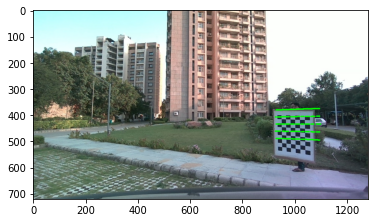

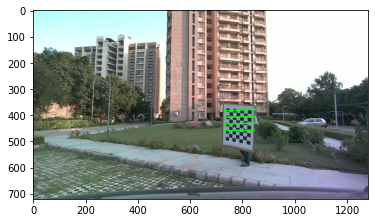

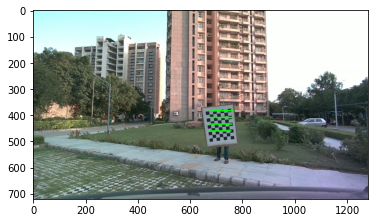

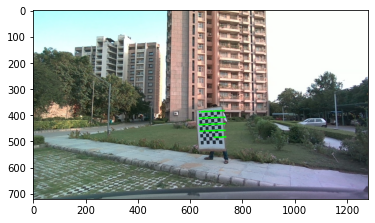

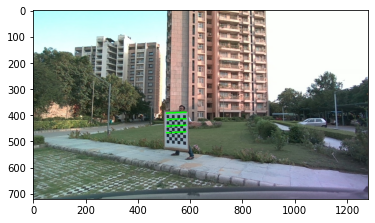

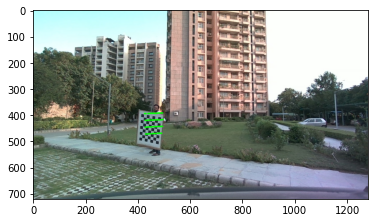

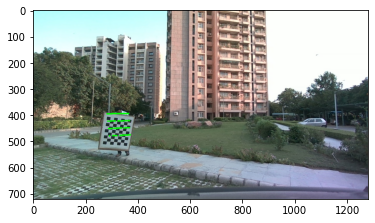

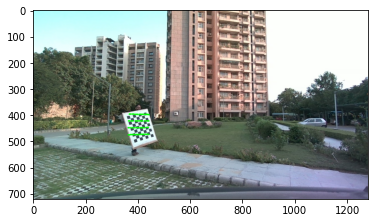

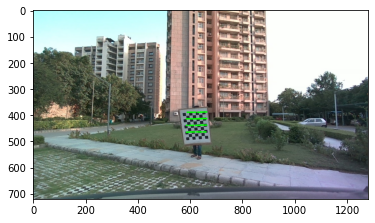

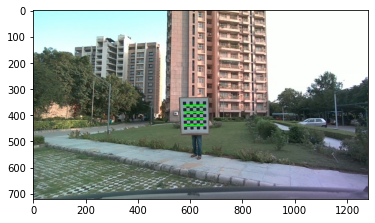

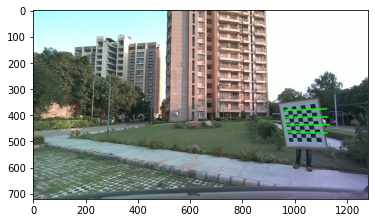

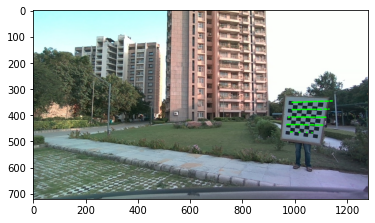

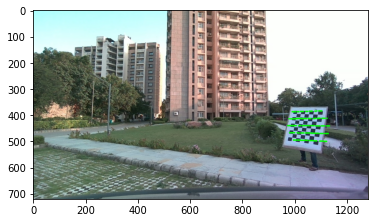

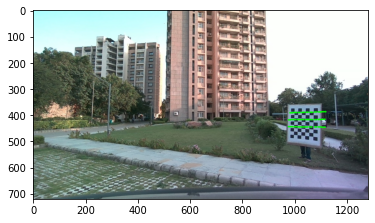

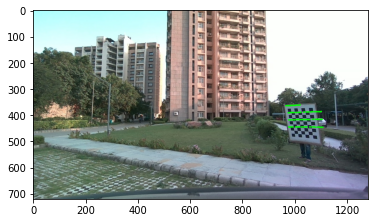

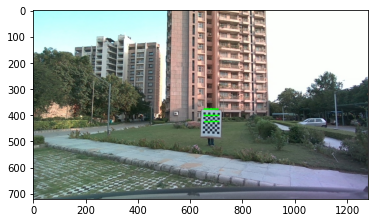

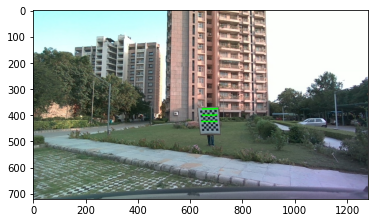

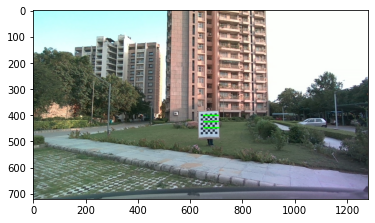

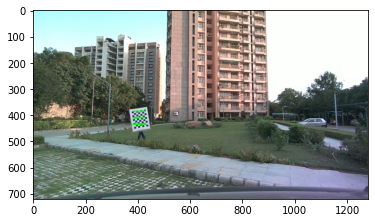

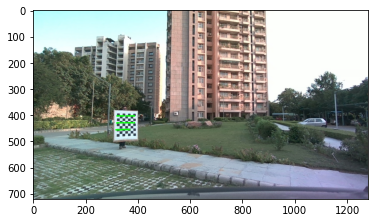

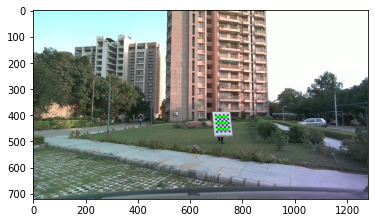

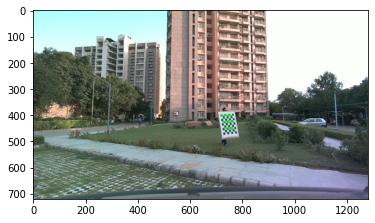

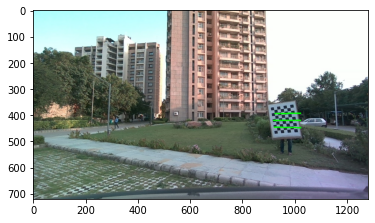

All points within the checkerboard pattern's boundary in each image? False


In [35]:
#boolean list to store whether corners inside the checkerboard pattern
projection = []

for lidar_scan, camera_image in zip(images, camera_image_files):

    cloud = PyntCloud.from_file(lidar_scan)
    lidar_points = np.array(cloud.points)
    lidar_points_homo = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1))))

    #LIDAR to camera 
    camera_points_homogeneous = np.dot(cTl, lidar_points_homo.T).T[:, :3]

    #camera onto image plane
    projected_points = np.dot(intrinsic, camera_points_homogeneous.T).T
    projected_points = (projected_points / projected_points[:, 2][:, np.newaxis])[:, :2]

    
    img = cv2.imread(camera_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

    if ret:
        
        for point in projected_points:
            x, y = point.astype(int)
            cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

        
        projection.append(all([cv2.pointPolygonTest(corners, (x, y), False) >= 0 for x, y in projected_points]))
       
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

all_in = all(projection)
print("All points within the checkerboard pattern's boundary in each image?", all_in)


In [36]:
#iterate over all images and store all camera normals

camera_normals_all=[]

dir='CV-A2-calibration/camera_parameters'

for filename in sorted(os.listdir(dir)):
    
    if not filename.endswith(".jpeg"):
        continue
   
    normal_c=dir+'/'+filename+'/camera_normals.txt'
    print(normal_c)

    with open(normal_c, 'r') as file:
        values = [float(line.strip()) for line in file]

        camera_normals_all.append(values)



CV-A2-calibration/camera_parameters/frame_1061.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1075.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1093.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1139.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1153.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1163.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1195.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1366.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1430.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1473.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1558.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1580.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1638.jpeg/camera_normals.txt
CV-A2-calibration/camera_parameters/frame_1698.jpeg/camera_normals.txt
CV-A2-

In [37]:
lidar_normals_all=[]
dir='CV-A2-calibration/lidar_scans'
images_all = []

for filename in sorted(os.listdir(dir)):
    if filename.endswith(".pcd"):
        images_all.append(os.path.join(dir, filename))
    
for path in images_all:
    cloud = PyntCloud.from_file(path)
    points = np.asarray(cloud.points)
    centroid = np.mean(points, axis=0)
    c_points = points - centroid
    u, si, vh = np.linalg.svd(c_points)
    normal = vh[-1]
    lidar_normals_all.append(normal)

In [38]:
camera_normals_all=np.array(camera_normals_all)
lidar_normals_all=np.array(lidar_normals_all)
print(camera_normals_all.shape)
print(lidar_normals_all.shape)

(38, 3)
(38, 3)


In [39]:
transformed_lidar_normals = np.dot(R, lidar_normals_all.T)

In [95]:
print(transformed_lidar_normals.shape)

(3, 38)


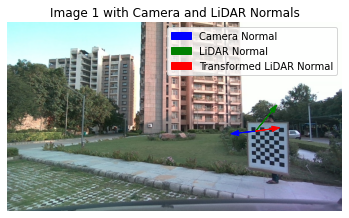

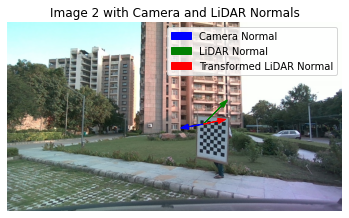

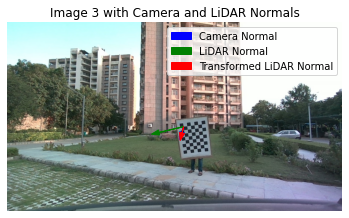

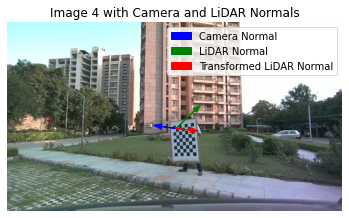

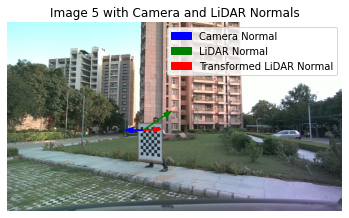

In [118]:
for i in range(5):
    image_path = camera_image_files[i]
    camera_normal = camera_normals_all[i]
    lidar_normal = lidar_normals_all[i]
    transformed_lidar_normal=transformed_lidar_normals[:,i]


    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    ret, corners = cv2.findChessboardCorners(image, (6, 8), None)

    if ret:
      
        start_point = tuple(corners[0][0])
        start_point = (int(start_point[0]), int(start_point[1]))

        scale = 100


        end_point_camera = (int(start_point[0] + camera_normal[0] * scale), int(start_point[1] + camera_normal[1] * scale))
        end_point_lidar = (int(start_point[0] + lidar_normal[0] * scale), int(start_point[1] + lidar_normal[1] * scale))
        end_point_transformed_lidar = (int(start_point[0] + transformed_lidar_normal[0] * scale), int(start_point[1] + transformed_lidar_normal[1] * scale))


        plt.imshow(image)
        plt.title(f"Image {i+1} with Camera and LiDAR Normals")
        plt.axis("off")

        # Plot the camera normal vector
        plt.arrow(start_point[0], start_point[1], end_point_camera[0] - start_point[0], end_point_camera[1] - start_point[1], color='blue', head_width=20, label='Camera Normal')

        # Plot the LiDAR normal vector
        plt.arrow(start_point[0], start_point[1], end_point_lidar[0] - start_point[0], end_point_lidar[1] - start_point[1], color='green', head_width=20, label='LiDAR Normal')

        # Plot the transformed LiDAR normal vector
        plt.arrow(start_point[0], start_point[1], end_point_transformed_lidar[0] - start_point[0], end_point_transformed_lidar[1] - start_point[1], color='red', head_width=20, label='Transformed LiDAR Normal')
 
        plt.legend()
        plt.show()

    else:
        break


In [119]:
print(camera_normals_all.shape)
print(transformed_lidar_normals.shape)

(38, 3)
(3, 38)


In [120]:

print(transformed_lidar_normals)

[[ 0.63789309  0.56335516 -0.05636977  0.54746254  0.39353462  0.18920867
  -0.35662283 -0.64495639  0.07149206  0.02055792 -0.65231683  0.41566145
  -0.66482056 -0.73709303 -0.79389461 -0.07992313  0.25060055 -0.14244722
  -0.30058554 -0.24244997  0.55348005  0.16185498 -0.39385435 -0.80309597
  -0.49665726 -0.65895457 -0.03729701  0.6708449  -0.4341211   0.39932979
   0.05724658 -0.03951896 -0.02947146  0.04097041  0.01706594  0.07590684
  -0.61441037 -0.53675402]
 [-0.08502711 -0.11470557  0.24270808  0.06666828 -0.01330849 -0.14101571
  -0.26126303  0.28371494 -0.24836555  0.24726761  0.17953116 -0.31414809
  -0.45265398 -0.11252095  0.23706797 -0.09563383 -0.22482379 -0.30372404
  -0.26920715  0.16087543 -0.18437375 -0.29933315  0.2333539   0.08448671
  -0.02226125  0.0547282   0.00759279 -0.07768497 -0.36851639 -0.39858705
  -0.06817764  0.5690477  -0.31911943 -0.06222161 -0.21755454  0.00575626
   0.063088   -0.00334718]
 [ 0.76541676  0.81821366 -0.96846023  0.83417031  0.91921

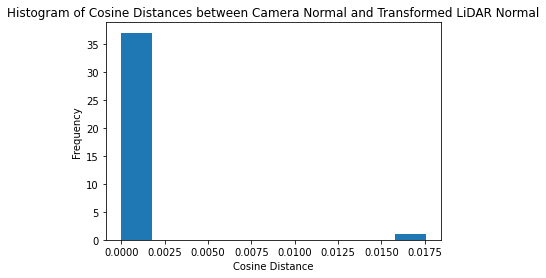

In [128]:
cosine_distances = []
for camera_normal, transformed_lidar_normal in zip(camera_normals_all, transformed_lidar_normals.T):
    cosine_similarity = np.dot(camera_normal, transformed_lidar_normal)/(np.linalg.norm(camera_normal) * np.linalg.norm(transformed_lidar_normal))
    if cosine_similarity <0:
        cosine_similarity = -cosine_similarity
    cosine_distance = 1 - cosine_similarity
    cosine_distances.append(cosine_distance)



plt.hist(cosine_distances)

plt.title('Histogram of Cosine Distances between Camera Normal and Transformed LiDAR Normal')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.show()


In [130]:
print("Mean error: ", np.mean(cosine_distances))
print("Standard deviation of error: ", np.std(cosine_distances))

Mean error:  0.0006586086344746269
Standard deviation of error:  0.0027892694145765676
